In [ ]:
%pip install spacy
%pip install textblob
%pip install spacytextblob
!python -m spacy download en_core_web_sm
!python -m textblob.download_corpora
%pip install ipywidgets

In [8]:
import os
import glob
import spacy
from textblob import TextBlob
from scipy.integrate import odeint
from tqdm.notebook import tqdm
import numpy as np
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import xml.etree.ElementTree as ET
from pathlib import Path
import matplotlib.pyplot as plt
import math
from transformers import BertTokenizer, BertModel
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity


# Load the English tokenizer, POS tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_sm")

In [2]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [53]:
def parse_xml_to_dataframe(file_path):
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    # Extracting play title
    play_title = root.find('TITLE').text

    # Extracting speaker and speech
    data = []
    for speech in root.iter('SPEECH'):
        speaker = speech.find('SPEAKER').text
        lines = [line.text for line in speech.findall('LINE') if line.text]
        speech_text = ' '.join(lines)
        data.append({'title':play_title,'speaker': speaker, 'speech': speech_text})

    # Creating DataFrame
    df = pd.DataFrame(data, columns=['title','speaker', 'speech'])
    return df


In [55]:
# Get all XML files in the zip folder
zip_file_path = 'data/corpora/shaks200.zip'
zip_file_name = os.path.basename(zip_file_path)
zip_file_name_no_ext = os.path.splitext(zip_file_name)[0]
zip_file_dir = os.path.dirname(zip_file_path)
zip_file_extracted_dir = os.path.join(zip_file_dir, zip_file_name_no_ext)
zip_file_extracted_dir = Path(zip_file_extracted_dir)

# Extract the zip file if it hasn't been extracted already
if not zip_file_extracted_dir.exists():
    import zipfile
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(zip_file_extracted_dir)

# Get all XML files in the extracted folder
xml_files = glob.glob(f'{zip_file_extracted_dir}/**/*.xml', recursive=True)
logging.info(f"Found {len(xml_files)} XML files")
# Parse each XML file into a DataFrame
dfs = []
for xml_file in tqdm(xml_files, desc="Parsing XML files"):
    df = parse_xml_to_dataframe(xml_file)
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)
df


2023-11-16 13:37:00,945 : INFO : Found 37 XML files
Parsing XML files: 100%|██████████| 37/37 [00:00<00:00, 161.58it/s]


,title,speaker,speech
0,The Second Part of Henry the Sixth,SUFFOLK,As by your high imperial majesty I had in char...
1,The Second Part of Henry the Sixth,KING HENRY VI,"Suffolk, arise. Welcome, Queen Margaret: I can..."
2,The Second Part of Henry the Sixth,QUEEN MARGARET,"Great King of England and my gracious lord, Th..."
3,The Second Part of Henry the Sixth,KING HENRY VI,"Her sight did ravish; but her grace in speech,..."
4,The Second Part of Henry the Sixth,ALL,happiness!
...,...,...,...
31023,The Tragedy of Antony and Cleopatra,First Guard,"O Caesar, This Charmian lived but now; she sto..."
31024,The Tragedy of Antony and Cleopatra,OCTAVIUS CAESAR,O noble weakness! If they had swallow'd poison...
31025,The Tragedy of Antony and Cleopatra,DOLABELLA,"Here, on her breast, There is a vent of blood ..."
31026,The Tragedy of Antony and Cleopatra,First Guard,This is an aspic's trail: and these fig-leaves...


In [57]:
# process each speech using spaCy
df['speech_processed'] = df['speech'].apply(lambda x: nlp(x))
df.head() # Displaying the first few rows of the DataFrame

,title,speaker,speech,speech_processed
0,The Second Part of Henry the Sixth,SUFFOLK,As by your high imperial majesty I had in char...,"(As, by, your, high, imperial, majesty, I, had..."
1,The Second Part of Henry the Sixth,KING HENRY VI,"Suffolk, arise. Welcome, Queen Margaret: I can...","(Suffolk, ,, arise, ., Welcome, ,, Queen, Marg..."
2,The Second Part of Henry the Sixth,QUEEN MARGARET,"Great King of England and my gracious lord, Th...","(Great, King, of, England, and, my, gracious, ..."
3,The Second Part of Henry the Sixth,KING HENRY VI,"Her sight did ravish; but her grace in speech,...","(Her, sight, did, ravish, ;, but, her, grace, ..."
4,The Second Part of Henry the Sixth,ALL,happiness!,"(happiness, !)"


In [58]:

def process_speeches(input_df, senticnet_path,):
    # Caricare SenticNet data
    senticnet_data = pd.read_csv(senticnet_path, delimiter="\t")
    categories = ['INTROSPECTION', 'TEMPER', 'ATTITUDE', 'SENSITIVITY']

    # Preparare il DataFrame per i risultati
    results = []
    

    for _, row in tqdm(input_df.iterrows(), total=input_df.shape[0]):
        speech_processed = row['speech_processed']
        speaker = row['speaker']
        speech = row['speech']
        title = row['title']

        # Accumulators for each category and emotion
        accumulators = {}
        polaritylist = []
        for sent in speech_processed.sents:
            for token in sent:
                token_text = token.text.lower()
                matching_row = senticnet_data[senticnet_data['CONCEPT'] == token_text]
                logging.debug(f"Token: {token_text}, matching row: {matching_row}")

                if not matching_row.empty:
                    # Find max and min categories
                    max_category = matching_row[categories].astype(float).idxmax(axis=1).iloc[0]
                    min_category = matching_row[categories].astype(float).idxmin(axis=1).iloc[0]
                    
                    primary_emotion = matching_row['PRIMARY EMOTION'].iloc[0]
                    secondary_emotion = matching_row['SECONDAY EMOTION'].iloc[0]
    
                    if pd.isna(primary_emotion):
                        max_emotion = max_category
                    else:
                        max_emotion = f"{max_category}{matching_row['PRIMARY EMOTION'].iloc[0]}"
    
                    if pd.isna(secondary_emotion):
                        min_emotion = min_category
                    else:
                        min_emotion = f"{min_category}{matching_row['SECONDAY EMOTION'].iloc[0]}"

                    if max_emotion not in accumulators:
                        accumulators[max_emotion] = []
                    if min_emotion not in accumulators:
                        accumulators[min_emotion] = []

                    accumulators[max_emotion].append(matching_row[max_category].iloc[0])
                    if max_emotion != min_emotion:
                        accumulators[min_emotion].append(matching_row[min_category].iloc[0])
                        
                    polarity = matching_row["POLARITY INTENSITY"].astype(float).iloc[0]
                    logging.debug(f"Token: {token_text}, polarity: {polarity}")
                    polaritylist.append(polarity)
                else:
                    logging.debug(f"Token: {token_text}, no matching row found")
                    
                   

        # Calculate averages for each emotion category
        emotion_avg = {emotion: sum(values) / len(values) if values else 0 for emotion, values in accumulators.items()}
        
        # Calculate average polarity for the speech
        polarity_avg = {"POLARITY": sum(polaritylist) / len(polaritylist) if polaritylist else 0}
        
        
        
        result_row = {'title':title,"speaker": speaker, "speech": speech, **emotion_avg, **polarity_avg}
        results.append(result_row)
    # drop columns with all 0
    results = pd.DataFrame(results).fillna(0)
    results = results.loc[:, (results != 0).any(axis=0)]
    
    # Verify that directory exists otherwise create it
    Path("results/speeches_processed.csv").parent.mkdir(parents=True, exist_ok=True)
    results.to_csv('results/speeches_processed.csv', index=False)
    return results
   

In [59]:
processed_df = process_speeches(df, 'data/senticnet/senticnet.tsv')
processed_df

100%|██████████| 31028/31028 [2:32:17<00:00,  3.40it/s]  


,title,speaker,speech,TEMPER#serenity,INTROSPECTION#acceptance,ATTITUDE#delight,INTROSPECTION,INTROSPECTION#ecstasy,INTROSPECTION#terror,SENSITIVITY#loathing,...,INTROSPECTION#sadness,ATTITUDE#responsiveness,ATTITUDE#contentment,SENSITIVITY#terror,SENSITIVITY#annoyance,ATTITUDE#dislike,INTROSPECTION#serenity,ATTITUDE#disgust,SENSITIVITY#fear,TEMPER#contentment
0,The Second Part of Henry the Sixth,SUFFOLK,As by your high imperial majesty I had in char...,0.26750,0.0000,0.934000,-0.027417,0.913000,0.000000,-0.965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,The Second Part of Henry the Sixth,KING HENRY VI,"Suffolk, arise. Welcome, Queen Margaret: I can...",0.25000,0.0000,0.000000,0.000000,0.899000,0.000000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,The Second Part of Henry the Sixth,QUEEN MARGARET,"Great King of England and my gracious lord, Th...",0.25725,0.0000,0.914500,0.000000,0.944200,0.000000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,The Second Part of Henry the Sixth,KING HENRY VI,"Her sight did ravish; but her grace in speech,...",0.00000,0.0000,0.931000,-0.266667,0.927333,0.000000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,The Second Part of Henry the Sixth,ALL,happiness!,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31023,The Tragedy of Antony and Cleopatra,First Guard,"O Caesar, This Charmian lived but now; she sto...",0.19600,0.0000,0.999000,-0.514667,0.934333,0.000000,-0.849,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31024,The Tragedy of Antony and Cleopatra,OCTAVIUS CAESAR,O noble weakness! If they had swallow'd poison...,0.26000,0.0000,0.933000,-0.415500,0.858000,0.000000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31025,The Tragedy of Antony and Cleopatra,DOLABELLA,"Here, on her breast, There is a vent of blood ...",0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31026,The Tragedy of Antony and Cleopatra,First Guard,This is an aspic's trail: and these fig-leaves...,0.00000,0.0000,0.000000,0.000000,0.886000,0.000000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
import torch

# Check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")



Using MPS


In [27]:

def distribute_scores_to_terms_using_bert(data: pd.DataFrame, tokenizer, model) -> pd.DataFrame:
    """
    Distributes scores to terms using BERT.

    Args:
        data (pd.DataFrame): DataFrame containing dialogues, speakers, and their corresponding emotional scores.
        tokenizer: Pre-loaded BERT tokenizer.
        model: Pre-loaded BERT model.

    Returns:
        pd.DataFrame: A DataFrame with scores distributed to terms using BERT.
    """

    def custom_scale(data, feature_range=(-1, 1)):
        non_zero_data = data[data != 0]
        if non_zero_data.shape[0] == 0:
            return data
        scaler = MinMaxScaler(feature_range=feature_range)
        scaled_non_zero_data = scaler.fit_transform(non_zero_data.values.reshape(-1, 1))
        data[data != 0] = scaled_non_zero_data.ravel()
        return data

    categories = list(data.columns[2:])  # Emotion categories start from the 3rd column
    main_categories = set(cat.split('#')[0] for cat in categories)

    # Building a dictionary of categories to their specific terms
    category_to_terms = {}
    for category in categories:
        main_cat, *specific_terms = category.split('#')
        if main_cat not in category_to_terms:
            category_to_terms[main_cat] = set()
        category_to_terms[main_cat].update(specific_terms)

    # Pre-compute term embeddings
    term_to_embedding = {}
    for main_category, terms in tqdm(category_to_terms.items(), desc="Pre-computing term embeddings", total=len(category_to_terms)):
        if not terms:  # Check if the terms list is empty
            logging.warning(f"No terms found for category {main_category}. Skipping.")
            continue

        try:
            inputs = tokenizer(list(terms), return_tensors='pt', truncation=True, padding=True, max_length=512)
            #inputs = {k: v.to(device) for k, v in inputs.items()}
            with torch.no_grad():
                outputs = model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
            for term, embedding in zip(terms, embeddings):
                term_to_embedding[f"{main_category}-{term}"] = embedding
        except Exception as e:
            logging.error(f"Error processing category {main_category} with terms {terms}: {e}")
            continue


    dialogues = data['Speech'].tolist()  # Use the 'Speech' column for dialogues
    inputs = tokenizer(dialogues, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    dialogue_embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

    output_data = data[['Speaker', 'Speech']].copy()
    # Initialize a DataFrame with zeros to store new columns data
    unique_terms = [f"{main_category}-{term}" for main_category, terms in category_to_terms.items()
                    for term in terms]
    new_columns_df = pd.DataFrame(0, index=np.arange(len(data)), columns=unique_terms)

    for idx, (dialogue_embedding, row) in tqdm(enumerate(zip(dialogue_embeddings, data.iterrows())), total=len(data), desc="Distributing scores to terms"):
        _, row = row
        for main_category in main_categories:
            score = row[main_category]
            if score == 0:
                continue

            terms = category_to_terms[main_category]
            similarities = {}
            for term in terms:
                term_embedding = term_to_embedding[f"{main_category}-{term}"]
                sim = cosine_similarity([dialogue_embedding], [term_embedding])[0][0]
                similarities[f"{main_category}-{term}"] = sim

            total_similarity = sum(similarities.values())
            if total_similarity == 0:
                continue

            normalized_similarities = {term: value / total_similarity for term, value in similarities.items()}
            for term, similarity in normalized_similarities.items():
                new_columns_df.at[idx, term] = score * similarity  # Update the DataFrame directly

    logging.debug(f"New Columns DataFrame shape: {new_columns_df.shape}")
    logging.debug(f"New Columns DataFrame null values: {new_columns_df.isnull().sum().sum()}")

    new_columns_df = new_columns_df.apply(custom_scale)
    output_data = pd.concat([output_data, new_columns_df], axis=1)

    return output_data


In [28]:
logging.info("Initializing BERT...")
bert_model = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model)
model = BertModel.from_pretrained(bert_model)
#model = model.to(device)

bert_processed_df = distribute_scores_to_terms_using_bert(processed_df, tokenizer, model)
bert_processed_df 

2023-11-16 12:06:58,864 : INFO : Initializing BERT...
Distributing scores to terms:   0%|          | 0/1138 [00:00<?, ?it/s]/var/folders/yg/_87t9jyn2jv8vtmqn44nhxy40000gn/T/ipykernel_37900/1112412443.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.04064493283356017' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_columns_df.at[idx, term] = score * similarity  # Update the DataFrame directly
/var/folders/yg/_87t9jyn2jv8vtmqn44nhxy40000gn/T/ipykernel_37900/1112412443.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.029812472134889474' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_columns_df.at[idx, term] = score * similarity  # Update the DataFrame directly
/var/folders/yg/_87t9jyn2jv8vtmqn44nhxy40000gn/T/ipykernel_37900/1112412443.py:86: Fu

,Speaker,Speech,TEMPER-contentment,TEMPER-calmness,TEMPER-sadness,TEMPER-serenity,TEMPER-fear,TEMPER-disgust,TEMPER-anger,TEMPER-dislike,...,SENSITIVITY-sadness,SENSITIVITY-disgust,SENSITIVITY-enthusiasm,SENSITIVITY-anger,SENSITIVITY-loathing,SENSITIVITY-responsiveness,SENSITIVITY-dislike,SENSITIVITY-annoyance,SENSITIVITY-anxiety,SENSITIVITY-eagerness
0,BERNARDO,Who's there?,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,FRANCISCO,"Nay, answer me: stand, and unfold yourself.",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,BERNARDO,Long live the king!,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,FRANCISCO,Bernardo?,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,BERNARDO,He.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133,First Ambassador,The sight is dismal; And our affairs from Engl...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.617043,0.594471,0.624545,0.601914,0.633262,0.609748,0.608072,0.601123,0.585476,0.658157
1134,HORATIO,"Not from his mouth, Had it the ability of life...",0.185917,0.200243,0.230511,0.194966,0.222217,0.210763,0.232338,0.277776,...,-0.630042,-0.758072,-0.653785,-0.740200,-0.587783,-0.757453,-0.733271,-0.714002,-0.748401,-0.513764
1135,PRINCE FORTINBRAS,"Let us haste to hear it, And call the noblest ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1136,HORATIO,"Of that I shall have also cause to speak, And ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [60]:

def navier_stokes_sentiment_flow(rho_sent, p_sent, nu_sent, g_context, s):
    """
Calculate the sentiment flow based on the Navier-Stokes equation.

The Navier-Stokes equation is a differential equation that describes the flow of fluid substances like liquids and gases. This function applies the same principles to model the flow of sentiment in a text.

Parameters:
rho_sent (float): The sentiment density, representing the amount of sentiment per unit of text.
p_sent (float): The sentiment pressure, representing the intensity of the sentiment.
nu_sent (float): The sentiment viscosity, representing the resistance to flow of the sentiment.
g_context (float): The external contextual force, representing the influence of the surrounding context on the sentiment.
s (float): The current sentiment state.

Returns:
float: The sentiment flow.
"""
    if rho_sent == 0:
        pressure_term = np.zeros_like(s)  # or some other appropriate handling
    else:
        pressure_term = -1 / rho_sent * np.gradient(p_sent)
        
    grad_s = np.gradient(s)
    laplacian_s = np.gradient(grad_s)
    
    if np.any(np.isnan(s)) or np.any(np.isinf(s)) or np.any(np.isnan(grad_s)) or np.any(np.isinf(grad_s)):
        logging.warning("Warning: NaN or inf detected in s or grad_s. Skipping this iteration.")
        return None  # Return None to indicate an issue

    convective_term = s * grad_s
    #pressure_term = -1 / rho_sent * np.gradient(p_sent)
    viscous_term = nu_sent * laplacian_s
    
    rhs = convective_term + pressure_term + viscous_term + g_context
    
    # Clamping: Prevent values from going to infinity
    np.clip(rhs, -1e10, 1e10, out=rhs)
    
    if np.any(np.isnan(rhs)) or np.any(np.isinf(rhs)):
        logging.warning("Warning: NaN or inf detected in rhs. Skipping this iteration.")
        return None  # Return None to indicate an issue
    
    logging.debug(f"Sentiment flow: {rhs}")
    
    return rhs

In [61]:
import numpy as np

def calculate_sentiment_density(sentiment_scores):
    """Calculate the density of sentiment from a list or array of sentiment scores."""
    return np.sum(np.abs(sentiment_scores))

def calculate_sentiment_pressure(score, keywords, text):
    """Calculate the sentiment pressure of a single sentiment score."""
    pressure = 0
    if any(keyword.lower() in text.lower() for keyword in keywords):
        pressure += score
    return pressure

def calculate_sentiment_viscosity(sentiment_scores):
    """Calculate the viscosity of sentiment from a list or array of sentiment scores."""
    return np.std(sentiment_scores)

def calculate_external_contextual_force(polarity):
    """
    Calculate the external contextual force for a given review using its POLARITY value.
    The POLARITY value directly represents the external contextual force.

    Args:
        polarity (float): The POLARITY value of the review.

    Returns:
        float: The external contextual force for the review.
    """
    return polarity


In [62]:
negative_words = [
    "abhorrent", "abrasive", "abrupt", "absurd", "abusive", "accidental", 
    "accusatory", "acerbic", "adverse", "aggressive", "alarmist", "alienating", 
    "angry", "annoyed", "annoying", "anxious", "apathetic", "appalling", 
    "arrogant", "ashamed", "awful", "awkward", "bad", "belligerent", 
    "bitter", "bizarre", "blame", "boring", "bothersome", "burdensome", 
    "callous", "chaotic", "clumsy", "coarse", "cold", "complacent", 
    "complaint", "complicated", "concerned", "confused", "contemptible", 
    "cruel", "crushing", "cynical", "damaging", "dangerous", "dark", 
    "deadly", "deceitful", "deceptive", "degrading", "dejected", "delinquent", 
    "deplorable", "depressed", "depressing", "desolate", "desperate", 
    "destructive", "detached", "detrimental", "devastating", "difficult", 
    "disappointing", "disastrous", "disdainful", "disgraceful", "disgusting", 
    "dishonest", "disillusioned", "dismissive", "displeased", "disruptive", 
    "dissatisfied", "distasteful", "distraught", "distressed", "disturbed", 
    "doubtful", "dreary", "dull", "dysfunctional", "embarrassing", "enraged", 
    "envy", "erratic", "evil", "excessive", "exhausting", "fearful", 
    "fearsome", "flawed", "foolish", "frantic", "frightening", "frustrating", 
    "futile", "gloomy", "grave", "greedy", "grim", "guilty", "harmful", 
    "hateful", "haunting", "hazardous", "helpless", "hopeless", "hostile"
]
positive_words = [
    "admirable", "adorable", "adventurous", "agreeable", "amazing", "ambitious", 
    "amiable", "amusing", "appealing", "appreciative", "articulate", "artistic", 
    "astonishing", "astute", "attentive", "attractive", "auspicious", "authentic", 
    "awesome", "beautiful", "beneficial", "blissful", "bountiful", "brave", 
    "bright", "brilliant", "bubbly", "calm", "capable", "captivating", "careful", 
    "charismatic", "charming", "cheerful", "cherished", "clever", "comforting", 
    "compassionate", "competent", "confident", "congenial", "considerate", 
    "content", "convivial", "courageous", "courteous", "creative", "cute", 
    "dazzling", "decent", "dedicated", "delightful", "dependable", "determined", 
    "diligent", "diplomatic", "dynamic", "eager", "earnest", "easygoing", 
    "ebullient", "educated", "effective", "efficient", "elegant", "eloquent", 
    "empathetic", "enchanting", "encouraging", "energetic", "engaging", 
    "enjoyable", "entertaining", "enthusiastic", "excellent", "exceptional", 
    "exciting", "exemplary", "exquisite", "extraordinary", "exuberant", 
    "fabulous", "fair", "faithful", "fantastic", "fascinating", "fearless", 
    "fine", "flourishing", "focused", "forgiving", "fortunate", "friendly", 
    "fun", "funny", "generous", "genial", "gentle", "genuine", "gifted", 
    "glorious", "good", "gracious", "grateful", "great", "happy", "harmonious", 
    "helpful", "hilarious", "honest", "honorable", "hopeful", "hospitable", 
    "humorous", "idealistic", "illustrious", "imaginative", "impressive", 
    "incredible", "independent", "industrious", "innovative", "insightful", 
    "inspiring", "intelligent", "intuitive", "inventive", "joyful", "jubilant", 
    "keen", "kind", "knowledgeable", "laudable", "lively", "lovable", "lovely", 
    "loving", "loyal", "lucky", "magnificent", "marvelous", "masterful", 
    "meticulous", "mindful", "miraculous", "modest", "motivated", "optimistic", 
    "outstanding", "passionate", "patient", "peaceful", "perfect", "persevering", 
    "persistent", "philanthropic", "playful", "pleasant", "pleasing", "poised", 
    "polished", "popular", "positive", "powerful", "praiseworthy", "precious", 
    "precise", "preeminent", "prestigious", "productive", "professional", 
    "proficient", "profound", "prolific", "prominent", "prosperous", "protective", 
    "proud", "prudent", "punctual", "purposeful", "qualified", "quintessential", 
    "radiant", "rational", "realistic", "reassuring", "receptive", "remarkable", 
    "resilient", "resolute", "resourceful", "respectable", "respectful", 
    "resplendent", "responsible", "responsive", "revered", "rewarding", "rich", 
    "righteous", "robust", "romantic", "sagacious", "satisfying", "savvy", 
    "scholarly", "scrupulous", "self-assured", "self-reliant", "sensible", 
    "sensitive", "serene", "sharp", "shining", "sincere", "skillful", "smart", 
    "smiling", "smooth", "sociable", "solid",
    "sophisticated", "spirited", "splendid", "steadfast", "stimulating",
    "stupendous", "stunning", "stupendous", "sturdy", "stylish", "suave",
    "sublime", "successful", "succinct", "super", "superb", "supportive",
    "surprising", "sustained", "sweet", "talented", "tenacious", "terrific",
    "thankful", "thoughtful", "thriving", "timely", "tireless", "tolerant",
    "top", "tranquil", "trusting", "truthful", "ultimate", "unbiased",
    "uncommon", "understanding", "unequaled", "unflappable", "unique"]

keywords_example = positive_words + negative_words

In [69]:

# Assuming the navier_stokes_sentiment_flow and other calculation functions are defined elsewhere

def differential_equation(s, t, rho_sent, p_sent, nu_sent, g_context):
    # Check the sizes of s and p_sent
    if len(s) != len(p_sent):
        raise ValueError("Mismatch in dimensions of s and p_sent")

    # Use the navier_stokes_sentiment_flow function to compute the derivative
    dsdt = navier_stokes_sentiment_flow(rho_sent, p_sent, nu_sent, g_context, s)

    # Ensure dsdt is the same size as s
    if len(dsdt) != len(s):
        raise ValueError("Mismatch in dimensions of dsdt and s")

    return dsdt

# Load your data
def calculate_navier_stocker(data):
    initial_conditions = []
    all_s = []
    sentiment_columns = data.columns.difference(['title','speaker', 'speech', 'POLARITY'])

    for speaker in tqdm(data['speaker'].unique()):
        title = data[data['speaker'] == speaker]['title'].iloc[0]
        speaker_data = data[data['speaker'] == speaker]
        logging.debug(f"Processing speaker: {speaker}, number of speeches: {len(speaker_data)}")
       
        initial_speech = speaker_data.iloc[0]

        # Convert sentiment data to floats and ensure it's an array
        s0 = initial_speech[sentiment_columns].apply(pd.to_numeric, errors='coerce').fillna(0).to_numpy()
        g_context = initial_speech['POLARITY']
        T = len(speaker_data)
        t = np.linspace(0, T-1, T)
        logging.debug(f"Initial time: {t}")

        if len(s0) < 2:
            continue
            
      
        rho_sent = calculate_sentiment_density(s0)
        # Ensure p_sent is calculated as an array of sentiment pressures
        p_sent = np.array([calculate_sentiment_pressure(score, keywords_example, initial_speech['speech']) for score in s0])
        nu_sent = calculate_sentiment_viscosity(s0)
        # Ensure all arrays are consistent in size
        if len(s0) != len(p_sent):
            continue

        # Use odeint to solve the differential equation
        s = odeint(differential_equation, s0.astype(float), t, args=(rho_sent, p_sent, nu_sent, g_context))

        initial_conditions.append({
            'title': title,
            'speaker': speaker,
            'initial speech': initial_speech['speech'],
            'initial sentiment': s[0],
            'initial POLARITY': g_context
        })
        all_s.append({
            'title': title,
            'speaker': speaker,
            'speech': speaker_data['speech'],
            'simulation': s,
        })

    return initial_conditions,all_s



In [70]:
bert_processed_df=pd.concat([bert_processed_df,processed_df['POLARITY']],axis=1)

In [71]:
initial_conditions, s =calculate_navier_stocker(processed_df)

  0%|          | 0/981 [00:00<?, ?it/s]/Users/dpicca/Library/Caches/pypoetry/virtualenvs/computionaltextdynamics-y-hZwXiu-py3.10/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
100%|██████████| 981/981 [04:34<00:00,  3.57it/s]


In [72]:
# Save the initial conditions to a CSV file
df_initial_conditions = pd.DataFrame(initial_conditions)
df_initial_conditions.to_csv('initial_conditions_pos.csv', index=False)


In [73]:
df_s = pd.DataFrame(s)
df_s.to_json('simulations.json', index=False)
df_s

,title,speaker,speech,simulation
0,The Second Part of Henry the Sixth,SUFFOLK,0 As by your high imperial majesty I ha...,"[[0.0, 0.2765, 0.0, 0.0, 0.0, 0.934, 0.0, 0.0,..."
1,The Second Part of Henry the Sixth,KING HENRY VI,"1 Suffolk, arise. Welcome, Queen Margare...","[[0.0, 0.329, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
2,The Second Part of Henry the Sixth,QUEEN MARGARET,2 Great King of England and my gracious...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.9145, 0.0, 0.0, 0..."
3,The Second Part of Henry the Sixth,ALL,4 ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,The Second Part of Henry the Sixth,GLOUCESTER,"7 king Charles, and William de la Pole,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...
976,The Tragedy of Antony and Cleopatra,Egyptian,30888 A poor Egyptian yet. The queen my mis...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
977,The Tragedy of Antony and Cleopatra,PROCULEIUS,30892 Caes...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
978,The Tragedy of Antony and Cleopatra,GALLUS,30904 You see how easily she may be surpris...,"[[0.0, 0.329, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
979,The Tragedy of Antony and Cleopatra,SELEUCUS,30949 ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## Use the mean of the simulations to plot the sentiment flow

In [82]:
df_s = pd.read_json('simulations.json')
# Funzione per calcolare la media delle simulazioni, gestendo valori None o non validi
def calculate_mean_simulation(simulations):
    valid_simulations = []

    # Filtrare simulazioni valide
    for sim in simulations:
        if sim is not None and isinstance(sim, list):
            try:
                valid_sim = np.array(sim, dtype=float)
                valid_simulations.append(valid_sim)
            except ValueError:
                logging.warning(f"Warning: Unable to convert simulation to array: {sim}")
                continue  # Ignorare simulazioni non convertibili in array numpy di float

    # Calcolare la media delle simulazioni valide
    if valid_simulations:
        return np.mean(np.stack(valid_simulations), axis=0)
    else:
        logging.warning("Warning: No valid simulations found")
        return None
# Numero di oratori nel dataset
num_speakers = len(df_s)

# Definire il numero di righe e colonne per la griglia di grafici
# Supponiamo di voler avere 3 colonne
num_cols = 3
num_rows = math.ceil(num_speakers / num_cols)

# Creare una griglia di subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Appiattire l'array di axes se è multidimensionale
if num_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes]
# Plottare i grafici in ogni cella della griglia
for index, (ax, row) in enumerate(zip(axes, df_s.iterrows())):
    # Accedere direttamente al nome dello speaker e ai dati di simulazione
    speaker_name = row[1]['speaker']
    simulation_data = row[1]['simulation']
    mean_simulation = calculate_mean_simulation(simulation_data)

    # Controllare se mean_simulation è valido
    # Controllare se mean_simulation è valido
    if mean_simulation is not None:
        ax.plot(mean_simulation)
        ax.set_title(f'Average Sentiment Flow for {speaker_name}')
    else:
        ax.set_title(f'No valid data for {speaker_name}')
        ax.axis('off')  # Nascondere gli axes se non ci sono dati validi

    ax.set_xlabel('Text Segment')
    ax.set_ylabel('Sentiment Value')

# Nascondere gli axes vuoti rimanenti
for index in range(len(df_s), len(axes)):
    axes[index].axis('off')

plt.tight_layout()
plt.show()


ValueError: Image size of 1500x163500 pixels is too large. It must be less than 2^16 in each direction.

Error in callback <function _draw_all_if_interactive at 0x11c543910> (for post_execute):


ValueError: Image size of 1500x163500 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1500x163500 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1500x163500 with 981 Axes>

## Plot the final sentiment value for each speaker

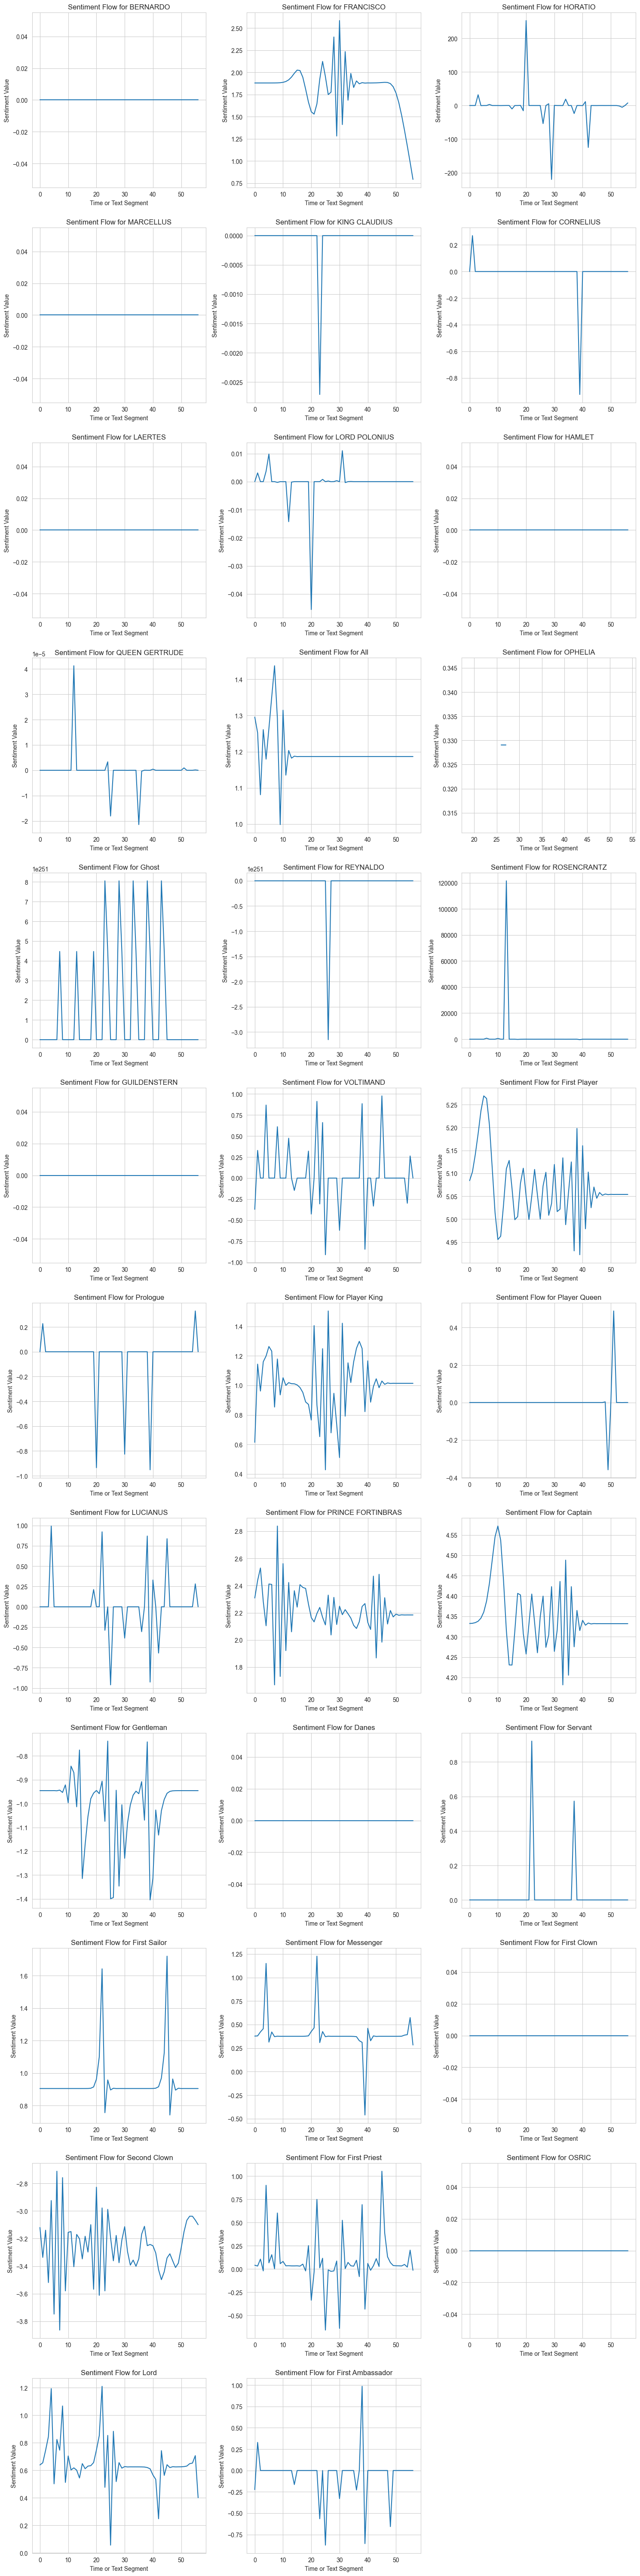

In [19]:


# Numero di oratori nel dataset
num_speakers = len(df_s)

# Definire il numero di righe e colonne per la griglia di grafici
# Supponiamo di voler avere 3 colonne
num_cols = 3
num_rows = math.ceil(num_speakers / num_cols)

# Creare una griglia di subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Appiattire l'array di axes se è multidimensionale
if num_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes]

# Plottare i grafici in ogni cella della griglia
for index, (ax, row) in enumerate(zip(axes, df_s.iterrows())):
    # Accedere direttamente al nome dello speaker e ai dati di simulazione
    speaker_name = row[1]['Speaker']
    simulation_data = row[1]['Simulation']
    final_simulation = simulation_data[-1]

    # Plottare il grafico
    ax.plot(final_simulation)
    ax.set_title(f'Sentiment Flow for {speaker_name}')
    ax.set_xlabel('Time or Text Segment')
    ax.set_ylabel('Sentiment Value')

# Nascondere gli axes vuoti se il numero di oratori non è un multiplo del numero di colonne
for index in range(len(df_s), len(axes)):
    axes[index].axis('off')

plt.tight_layout()
plt.show()


## Choose the simulation that shows the greatest variation or most interesting dynamics in feelings. 

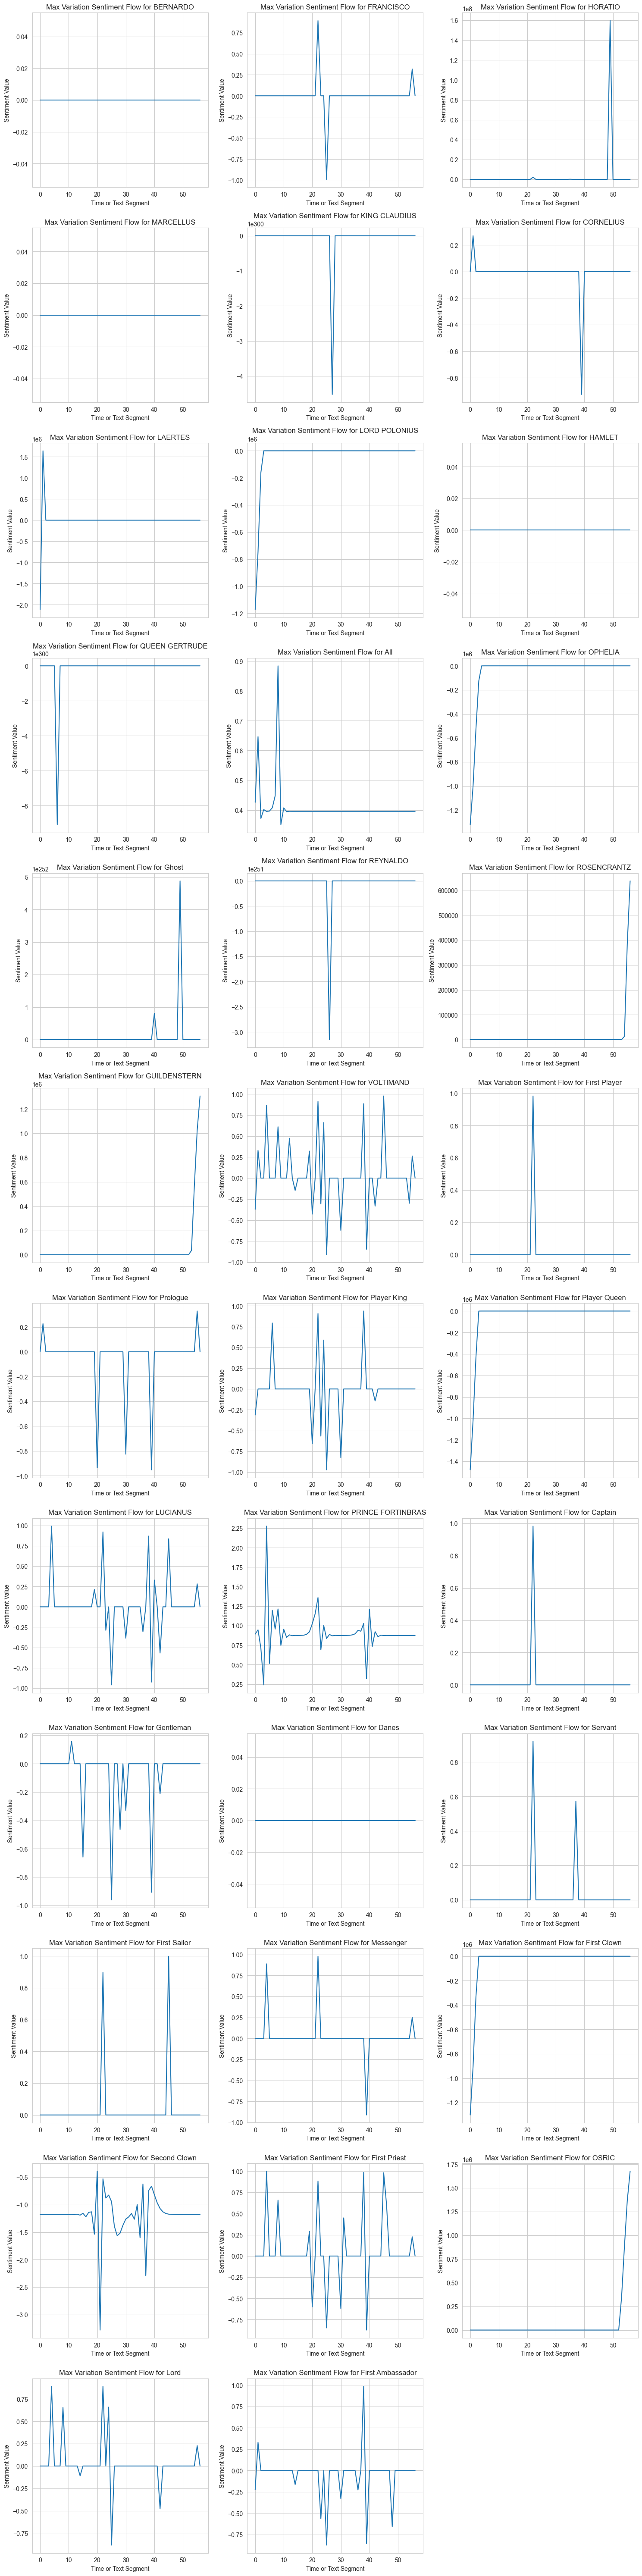

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Caricare i dati dal file JSON fornito
file_path_json = 'simulations.json'
data_json = pd.read_json(file_path_json)

# Funzione per calcolare la variazione di una simulazione
# Funzione per calcolare la variazione di una simulazione
def calculate_variation(simulation):
    try:
        if simulation is not None and isinstance(simulation, list):
            np_sim = np.array(simulation)
            return np.max(np_sim) - np.min(np_sim)
    except TypeError:
        # Gestione dei valori None o altri tipi di dati non validi
        pass
    return -1  # Valore negativo per simulazioni non valide o mancanti

# Funzione per trovare la simulazione con la maggiore variazione
def find_simulation_with_max_variation(simulations):
    max_variation = -1
    max_var_sim = None

    for sim in simulations:
        variation = calculate_variation(sim)
        if variation > max_variation:
            max_variation = variation
            max_var_sim = sim

    return max_var_sim

# Numero di oratori nel dataset
num_speakers = len(data_json)

# Definire il numero di righe e colonne per la griglia di grafici
num_cols = 3
num_rows = math.ceil(num_speakers / num_cols)

# Creare una griglia di subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Appiattire l'array di axes se è multidimensionale
if num_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes]

# Plottare i grafici in ogni cella della griglia
for index, (ax, row) in enumerate(zip(axes, data_json.iterrows())):
    speaker_name = row[1]['Speaker']
    simulation_data = row[1]['Simulation']
    max_var_simulation = find_simulation_with_max_variation(simulation_data)

    # Controllare se max_var_simulation è valido
    if max_var_simulation is not None:
        ax.plot(max_var_simulation)
        ax.set_title(f'Max Variation Sentiment Flow for {speaker_name}')
    else:
        ax.set_title(f'No valid data for {speaker_name}')
        ax.axis('off')  # Nascondere gli axes se non ci sono dati validi

    ax.set_xlabel('Time or Text Segment')
    ax.set_ylabel('Sentiment Value')

# Nascondere gli axes vuoti rimanenti
for index in range(len(data_json), len(axes)):
    axes[index].axis('off')

plt.tight_layout()
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Function to plot a subset of speakers with adjusted settings
def plot_speakers(df, speaker_indices, fig_num):
    num_speakers = len(speaker_indices)
    # Increase the figure size
    fig, axes = plt.subplots(nrows=num_speakers, ncols=1, figsize=(15, 6 * num_speakers))

    for i, idx in enumerate(speaker_indices):
        row = df.iloc[idx]
        simulation_data = np.array(row['Simulation'])
        ax = axes[i] if num_speakers > 1 else axes

        for sentiment_idx in range(simulation_data.shape[1]):
            ax.plot(simulation_data[:, sentiment_idx], label=f'Sentiment {sentiment_idx+1}')

        ax.set_title(f'Speaker: {row["Speaker"]}', fontsize=14)
        ax.set_xlabel('Time', fontsize=12)
        ax.set_ylabel('Sentiment Value', fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.legend(fontsize=10)

    plt.tight_layout()
    plt.savefig(f'navier_stocker_speakers_fig_{fig_num}.png')
    plt.show()

# Plotting in chunks with fewer speakers per plot
speakers_per_plot = 3  # Reduce the number of speakers per plot
total_speakers = len(df_s)

for i in range(0, total_speakers, speakers_per_plot):
    plot_speakers(df_s, range(i, min(i + speakers_per_plot, total_speakers)), i // speakers_per_plot + 1)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# Preparing data for visualization
features = ['initial_s', 'initial_rho_sent', 'initial_p_sent', 'initial_nu_sent', 'initial_g_context']

# Creating a figure with multiple subplots for each feature
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle('Distribution and Relationships of Initial Sentiment Analysis Conditions', fontsize=16)

# Looping through the features to create distribution plots
for i, feature in enumerate(features):
    row, col = divmod(i, 3)
    
    sns.histplot(df_initial_conditions[feature], kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {feature}')
    axes[row, col].set_xlabel('Value')
    axes[row, col].set_ylabel('Frequency')

# Removing the empty subplot (if any)
if len(features) % 3 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
# Supponendo che initial_conditions sia una lista di dizionari
df_initial_conditions = pd.DataFrame(initial_conditions)

# Ora puoi usare sns.histplot con il DataFrame
sns.histplot(df_initial_conditions['initial_s'], kde=True)
plt.title('Distribution of Initial Sentiments')
plt.xlabel('Initial Sentiment (initial_s)')
plt.show()

In [ ]:
# Analyze the rate of change of sentiment
sns.histplot(df_initial_conditions['initial_rho_sent'], kde=True)
plt.title('Distribution of Rate of Change of Sentiment')
plt.xlabel('Rate of Change of Sentiment (initial_rho_sent)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Analyze the external pressure on sentiment
sns.histplot(df_initial_conditions['initial_p_sent'], kde=True)
plt.title('Distribution of External Pressure on Sentiment')
plt.xlabel('External Pressure on Sentiment (initial_p_sent)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Analyze the internal adjustment to sentiment
sns.histplot(df_initial_conditions['initial_nu_sent'], kde=False)
plt.title('Distribution of Internal Adjustment to Sentiment')
plt.xlabel('Internal Adjustment to Sentiment (initial_nu_sent)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Analyze the context of sentiment expression
sns.histplot(df_initial_conditions['initial_g_context'], kde=True)
plt.title('Distribution of Context of Sentiment Expression')
plt.xlabel('Context of Sentiment Expression (initial_g_context)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 's' is your multi-dimensional array
# s = np.array([...])  # Your sentiment data

# Determine the number of dimensions to plot
num_dimensions = s.shape[1]

# Create a subplot for each dimension
fig, axes = plt.subplots(num_dimensions, 1, figsize=(10, num_dimensions * 3))

# Plotting each dimension
for i in range(num_dimensions):
    axes[i].plot(s[:, i])
    axes[i].set_title(f"Dimension {i+1} of Sentiment Flow")
    axes[i].set_xlabel("Time or Sequence")
    axes[i].set_ylabel("Sentiment Value")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:

# Pairwise relationships
sns.pairplot(df_initial_conditions)
plt.suptitle('Pairwise Relationships Between Parameters', y=1.02)
plt.show()

In [ ]:
# Correlation matrix heatmap
corr = df_initial_conditions.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Simulation Parameters')
plt.show()

In [ ]:
# Look for anomalies or patterns
# Here you can include any specific analysis based on your hypotheses
# For example, to test if initial sentiment and rate of change are correlated:
correlation = df_initial_conditions['initial_s'].corr(df_initial_conditions['initial_rho_sent'])
print(f'Correlation between initial sentiment and rate of change: {correlation}')

# If you have specific hypotheses, you can perform statistical tests here
# For example, a t-test, chi-square test, etc., depending on your hypotheses and data type


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Assuming 's' is the sentiment state variable updated during the simulation
# and each row in 's' corresponds to a different piece of text

# Step 1: Basic Statistics
# Calculate mean, standard deviation, etc.
mean_sentiment = np.mean(s, axis=0)
std_sentiment = np.std(s, axis=0)

print(f"Mean Sentiment: {mean_sentiment}")
print(f"Standard Deviation of Sentiment: {std_sentiment}")

# Step 2: Z-Score Normalization
# This will help us identify outliers or exceptionally strong sentiments
z_scores = zscore(s, axis=0)

In [ ]:

# Step 4: Heatmap for Sentiment Evolution
# This will show us how the sentiment evolves for all pieces of text
s_reshaped = s.reshape(-1, 1)  # Reshape to 2D array with one column

plt.figure(figsize=(10, 6))
sns.heatmap(s_reshaped, cmap='coolwarm', cbar=True)
plt.title('Heatmap of Sentiment Flow Over Time')
plt.xlabel('Time Step')
plt.ylabel('Text Index')
plt.show()

In [ ]:

# Step 5: Clustering (Optional)
# You can use clustering algorithms like K-means to group similar sentiment flows together
from sklearn.cluster import KMeans
# Assuming 's' is your 1D array
s_reshaped = s.reshape(-1, 1)  # Reshape the array to 2D

kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(s_reshaped)

# Add the cluster labels back to your DataFrame (if you're using one)
# df['Cluster'] = clusters

# Now you can analyze each cluster separately to understand its characteristics
